Import des bibliothèques 

In [30]:
import numpy as np
import os
from PIL import Image 
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model

Chargement des données

In [31]:

csv_train = pd.read_csv('boneage_training_dataset_300.csv') 
csv_test = pd.read_csv('boneage_test_dataset_100.csv')

# Conversion en array du csv pour manipulation plus facile 

### Pour la base d'apprentissage
train_array = csv_train.to_numpy()

numero_patient_train = train_array[:,0]
age_osseux_train = train_array[:,1]
sexe_train = train_array[:,2]

### Pour la base de test 
test_array = csv_test.to_numpy()
numero_patient_test = test_array[:,0]
age_osseux_test = test_array[:,1]
sexe_test = test_array[:,2]


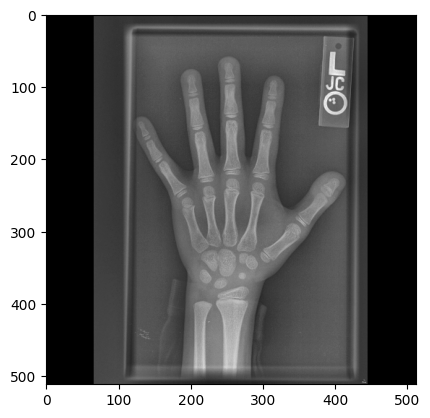

In [32]:

def chargement_images_train_2(numero_patient_train):
    img_path = f'training/{numero_patient_train}.png'
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img, 512, 512)
    img = tf.image.rgb_to_grayscale(img)

    def _clahe(img_np):
        img_np = img_np.numpy().astype(np.uint8)  # on convertit en numpy pour appliquer le CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img_np[:, :, 0])         # canal unique (gris)
        return enhanced.astype(np.uint8)

    img = tf.py_function(func=_clahe, inp=[img], Tout=tf.uint8)
    img = tf.cast(img, tf.float32) / 255.0

    return img


def chargement_images_test(numero_patient_train):
    img_path = f'test/{numero_patient_train}.png'
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img,512,512) #pad car image rectangulaire paysage et portrait et dim différentes
    img = tf.image.rgb_to_grayscale(img)

    def _clahe(img_np):
        img_np = img_np.numpy().astype(np.uint8)  # on convertit en numpy pour appliquer le CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img_np[:, :, 0])         # canal unique (gris)
        return enhanced.astype(np.uint8)

    img = tf.py_function(func=_clahe, inp=[img], Tout=tf.uint8)
    img = tf.cast(img, tf.float32) / 255.0

    return img 

plt.figure()
plt.imshow(chargement_images_train_2(1700).numpy().squeeze(), cmap='gray')

In [33]:

img_path_k_train = []

for k in numero_patient_train:
    img_path_k_train.append(f'training/{k}.png')
img_path_array = np.array(img_path_k_train)


X_train_images = img_path_array
X_train_sex = np.array([1 if s == True else 0 for s in sexe_train])
y_train = age_osseux_train.astype('float32')

numero_patient_train = train_array[:,0]
age_osseux_train = train_array[:,1]
sexe_train = train_array[:,2]

### Pour la base de test 
test_array = csv_test.to_numpy()
numero_patient_test = test_array[:,0]
age_osseux_test = test_array[:,1]
sexe_test = test_array[:,2]



img_path_k_test = []

for k in numero_patient_test:
    img_path_k_test.append(f'test/{k}.png')
img_path_array_test = np.array(img_path_k_test)


X_test_images = img_path_array_test
X_test_sex = np.array([1 if s == True else 0 for s in sexe_test])
y_test = age_osseux_test.astype('float32')

print(X_train_images)


['training/1600.png' 'training/1601.png' 'training/1602.png' ...
 'training/2703.png' 'training/2704.png' 'training/2705.png']


Dimension du array contenant les chemins des images de la base d'apprentissage : (1001,)
Dimension du array contenant les sexes des pateients :  (1001,)
Dimension du array contenant les labels d'age osseux : (1001,)
Dimension du array contenant les chemins des images de la base de test : (100,)
Dimension du array contenant les sexes de la base de test : (100,)


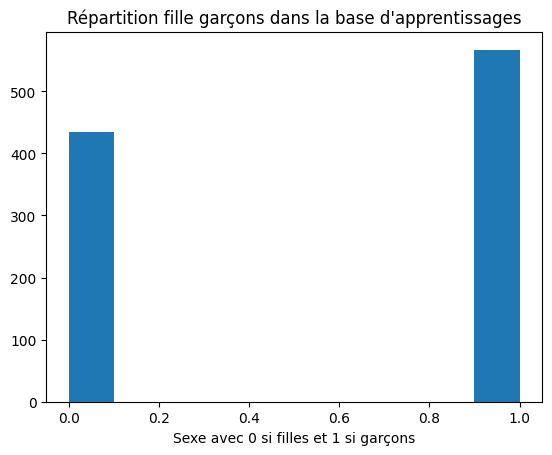

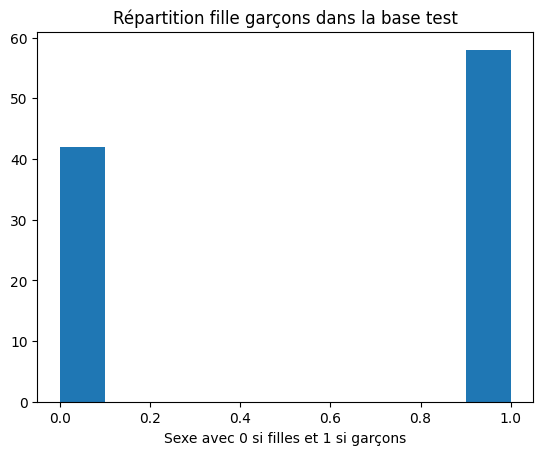

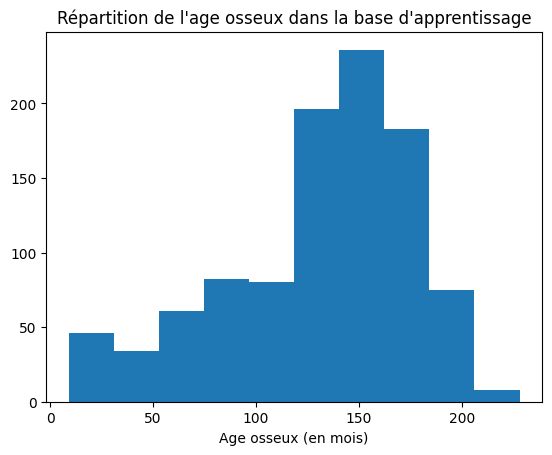

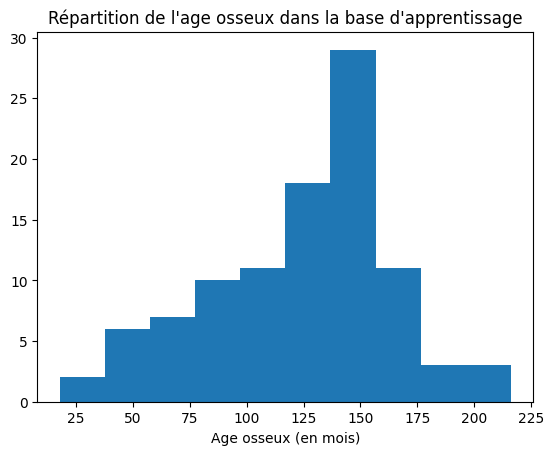

In [34]:

print("Dimension du array contenant les chemins des images de la base d'apprentissage :",X_train_images.shape)
print("Dimension du array contenant les sexes des pateients : ",X_train_sex.shape)
print("Dimension du array contenant les labels d'age osseux :",y_train.shape)

print("Dimension du array contenant les chemins des images de la base de test :",X_test_images.shape)
print("Dimension du array contenant les sexes de la base de test :",X_test_sex.shape)

plt.figure()
plt.hist(X_train_sex)
plt.title("Répartition fille garçons dans la base d'apprentissages")
plt.xlabel("Sexe avec 0 si filles et 1 si garçons")
plt.show()

plt.figure()
plt.hist(X_test_sex)
plt.title("Répartition fille garçons dans la base test")
plt.xlabel("Sexe avec 0 si filles et 1 si garçons")
plt.show()

plt.figure()
plt.hist(y_train)
plt.title("Répartition de l'age osseux dans la base d'apprentissage")
plt.xlabel("Age osseux (en mois)")
plt.show()

plt.figure()
plt.hist(y_test)
plt.title("Répartition de l'age osseux dans la base d'apprentissage")
plt.xlabel("Age osseux (en mois)")
plt.show()

Pour le modèle, on choisit une approche de transfer learning (prendre un modèle déjà entraîné et on le réutilise pour notre objectif) avec Xception (CNN déjà entraîné sur des millions d'images (ImageNet)). On fait ça pour pas qu'on ait à réentraîner un modèle depuis zéro (trop long).

On enlève juste la dernière couche de Xception (celle qui faisait la classification) et on ajoute nos propres couches pour faire une régression et prédire l'âge osseux. Par contre, on donne deux entrées au modèle (images + sexe) parce que la croissance osseuse n'est pas la même entre filles et garçons.

Donc on fait :
    - on gèle Xception et on entraîne seulement les nouvelles couches qu'on a ajoutées
    - on débloque les dernières couches de Xception pour faire un fine-tuning : le modèle ajuste ses filtres pour mieux comprendre les radio

A la fin, on évalue les prédictions avec la MAE (mean absolute error), qui indique en moyenne de combien de mois le modèle se trompe

In [35]:
# Modèle 

from tensorflow.keras.preprocessing import image

IMG_SIZE = (299, 299) # le model Xception attend des images de cette dimension

def load_images(img_paths):
    imgs = []
    for path in img_paths:
        img = image.load_img(path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)
        imgs.append(img_array)
    return np.array(imgs)

# Chargement des images
X_train_images_array = load_images(X_train_images)
X_test_images_array = load_images(X_test_images)    

print(X_test_images_array.shape)

(100, 299, 299, 3)


In [36]:
# entrées
input_img = Input(shape=(299, 299, 3))
input_sex = Input(shape=(1,))

# abse Xception pré-entraînée
base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_img)
base_model.trainable = False  # gel de la base pour le début

# sortie de Xception -> on applique un pooling global
x = base_model.output
x = GlobalAveragePooling2D()(x) # ça résume les infos extraites des images


x = Concatenate()([x, input_sex]) # on ajoute le sexe

x = Dense(128, activation='relu')(x) # couche fullt connected (transforment caractéristiques en âge)
output = Dense(1, activation='linear')(x)  # régression âge en mois

# Modèle final
model_baseline_sex = Model(inputs=[input_img, input_sex], outputs=output) #la couche finale renvoie un âge 
#model_baseline_sex.summary()


In [ ]:
# on entraîne que les nouvelles couches comme ça on modifie pas les poids pré-entrainés

from tensorflow.keras.callbacks import EarlyStopping

model_baseline_sex.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

entrainement_phase1 = model_baseline_sex.fit(
    [X_train_images_array, X_train_sex], y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping('val_loss', patience=10, restore_best_weights=True)
    ]
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 359s 13s/step - loss: 100.2528 - mae: 100.2528 - val_loss: 86.7128 - val_mae: 86.7128
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - loss: 47.2552 - mae: 47.2552 - val_loss: 36.7971 - val_mae: 36.7971
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 237s 10s/step - loss: 36.0858 - mae: 36.0858 - val_loss: 35.5152 - val_mae: 35.5152
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 235s 9s/step - loss: 33.1958 - mae: 33.1958 - val_loss: 33.0787 - val_mae: 33.0787
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 231s 9s/step - loss: 30.9712 - mae: 30.9712 - val_loss: 31.5456 - val_mae: 31.5456
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - loss: 29.0130 - mae: 29.0130 - val_loss: 29.2508 - val_mae: 29.2508
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 237s 10s/step - loss: 27.1847 - mae: 27.1847 - val_loss: 26.2702 - val_mae: 26.2702
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 273s 11s/step - loss: 25.7313 - mae: 25.7313 - val_loss: 26.3506 - val_mae: 26.3506
Epoch 9/20
25/25 ━━━━━━━

In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

# fine-tuning effectué avec un learning rate plus petit (on essaye d'affiner le modèle, on ajuste les dernières couches)
model_baseline_sex.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='mean_absolute_error',
    metrics=['mae']
)

# on continue l'engtraînement
entrainement_phase2 = model_baseline_sex.fit(
    [X_train_images_array, X_train_sex], y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[
        EarlyStopping('val_loss', patience=10, restore_best_weights=True)
    ]
)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 316s 12s/step - loss: 39.5429 - mae: 39.5429 - val_loss: 31.3557 - val_mae: 31.3557
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 11s/step - loss: 32.0448 - mae: 32.0448 - val_loss: 39.5491 - val_mae: 39.5491
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 271s 11s/step - loss: 28.1017 - mae: 28.1017 - val_loss: 37.6367 - val_mae: 37.6367
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 250s 10s/step - loss: 25.3216 - mae: 25.3216 - val_loss: 31.4946 - val_mae: 31.4946
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 253s 10s/step - loss: 21.5703 - mae: 21.5703 - val_loss: 27.5758 - val_mae: 27.5758
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - loss: 18.7158 - mae: 18.7158 - val_loss: 26.2793 - val_mae: 26.2793
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 272s 11s/step - loss: 18.9142 - mae: 18.9142 - val_loss: 24.4104 - val_mae: 24.4104
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 245s 10s/step - loss: 16.0753 - mae: 16.0753 - val_loss: 23.7933 - val_mae: 23.7933
Epoch 9/30
25/25 ━━━━━━━━

In [2]:
# ça fonctionne pas parce que mon kernel s'est déconnecté et il faudrait que je relance tout le code mais il met 4h à tourner donc bon

# prédictions sur la base de test
y_pred = model_baseline_sex.predict([X_test_images_array, X_test_sex])
print("y_pred: ", y_pred)
print("y_test: ", y_test)

# calcul de la MAE
mae = np.mean(np.abs(y_pred.flatten() - y_test))
print("MAE:", mae)

# distribution des résidus
residuals = y_test - y_pred.flatten()
plt.hist(residuals, bins=30)
plt.title("Distribution des résidus")
plt.xlabel("Erreur (mois)")
plt.ylabel("Nombre d'échantillons")
plt.show()

NameError: name 'model_baseline_sex' is not defined

On a une MAE de 19, peut mieux faire...

améliorations possibles : 
- créer une base validation et ne pas la prendre de la base d'apprentissage
- faire du data augmentation
- augmenter le nombre d'epochs (mais très long à exécuter)
